# Model with pretrained embeddings
    - Glove embeddings. Vectors of 300 dim.
    - Model: Basic LSTM.


## Preprocess data

In [1]:
#Imports 
import numpy as np
import os
import shutil
import fnmatch

from collections import OrderedDict
from nltk import word_tokenize

data_path='/home/ubuntu/data/training/keras/aclImdb/'



# Generator of list of files in a folder and subfolders
def gen_find(filepath,top):
    for path, dirlist, filelist in os.walk(top):
        for name in fnmatch.filter(filelist,filepath):
            yield os.path.join(path,name)

def read_sentences(path):
    sentences = []
    sentences_list = gen_find("*.txt", path)
    for ff in sentences_list:
        with open(ff, 'r') as f:
            sentences.append(f.readline().strip())
    return sentences 

def tokenize(sentences):
    print 'Tokenizing...',
    tokens = []
    for sentence in sentences:
        tokens += [word_tokenize(sentence.decode('utf-8'))]
    print('Done!')
    return tokens

def build_dict(sentences):
    print 'Building dictionary..',
    wordcount = dict()
    for ss in sentences:
        for w in ss:
            if w not in wordcount:
                wordcount[w] = 1
            else:
                wordcount[w] += 1

    counts = wordcount.values()
    keys = wordcount.keys()
    sorted_idx = np.argsort(counts)[::-1]

    worddict = dict()
    for idx, ss in enumerate(sorted_idx):
        worddict[keys[ss]] = idx+2  # leave 0 and 1 (UNK)
    print np.sum(counts), ' total words ', len(keys), ' unique words'
    return worddict, wordcount

def generate_sequence(sentences, dictionary):
    seqs = [None] * len(sentences)
    for idx, ss in enumerate(sentences):
        seqs[idx] = [dictionary[w] if w in dictionary else 1 for w in ss]
    return seqs

#Data extraction

#Extract training sentences
sentences_trn_pos = tokenize(read_sentences(data_path+'train/pos/'))
sentences_trn_neg = tokenize(read_sentences(data_path+'train/neg/'))
sentences_trn = sentences_trn_pos + sentences_trn_neg

#Build train dictionary
worddict, wordcount = build_dict(sentences_trn)

#Generate train data
train_x_pos = generate_sequence(sentences_trn_pos, worddict)
train_x_neg = generate_sequence(sentences_trn_neg, worddict)
X_train = train_x_pos + train_x_neg
y_train = [1] * len(train_x_pos) + [0] * len(train_x_neg)


#Read test sentences and generate target y
sentences_tst_pos = read_sentences(data_path+'test/pos/')
sentences_tst_neg = read_sentences(data_path+'test/neg/')

test_x_pos = generate_sequence(tokenize(sentences_tst_pos), worddict)
test_x_neg = generate_sequence(tokenize(sentences_tst_neg), worddict)
X_test = test_x_pos + test_x_neg
y_test = [1] * len(test_x_pos) + [0] * len(test_x_neg)


print('Preprocess done!')

Tokenizing... Done!
Tokenizing... Done!
Building dictionary.. 7056193  total words  135098  unique words
Tokenizing... Done!
Tokenizing... Done!
Preprocess done!


## Load embeddings and join with the current dictionary

In [2]:
#Load embeddings
import pandas as pd
import csv

embed_dim = 300

embedding_path = '/home/ubuntu/data/training/keras/'
df_glove = pd.read_csv(embedding_path + "glove.6B."+str(embed_dim)+"d.txt", index_col=0 ,sep=' ',
                   header = None, quoting=csv.QUOTE_NONE, encoding='utf-8')

#Merge with the dictionary of the current texts: Inner join, only words in the corpus and in glove.
df_glove = df_glove.merge(pd.DataFrame.from_dict(worddict, orient='index'), left_index=True, right_index=True)
print df_glove.shape

#Create dictionary: word_number_id --> [glove vector associated]
glove={}
for i,r in df_glove[:].iterrows():
    glove[int(r[0])] = [r[j] for j in range(1,embed_dim+1)]
print len(glove)

(45934, 301)
45934


## Prepare sequences to model


In [3]:
#Create embeddings 3D tensors
max_len = 100

def embedd(x):
    r = np.zeros((max_len, embed_dim))
    pos = max_len-1
    for i in xrange(len(x),0,-1):
        found = True
        try:
            v = np.array([glove[x[i-1]]])
        except:
            found = False
        if found and pos>=0:
            r[pos,:] = v 
            pos += -1
    return r
        
X_train = np.array([embedd(s) for s in X_train], dtype=np.float32)
print X_train.shape

X_test = np.array([embedd(s) for s in X_test], dtype=np.float32)
print X_test.shape

(25000, 100, 300)
(25000, 100, 300)


In [4]:
# Shuffle data
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=0)

## Build model

In [5]:
# Model
num_hidden_rnn = 128 #Num of neurons in the Recurent network 


from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Dropout, Dense, merge
from keras.optimizers import RMSprop

print('Build model 1 - Basic model...')

# LAYER 1: inputs
seq_prev_input = Input(shape=(max_len, embed_dim), dtype='float32') 

# LAYER 2: Create embedings
#embeds = Embedding(max_features, dim_embedings, input_length=max_len)(seq_prev_input)

# LAYERS 3: RNN - forwards LSTM with dropout
forward = LSTM(num_hidden_rnn, return_sequences=True,
                 dropout_W=0.3, dropout_U=0.3, name='Forward1')(seq_prev_input)
rnn_out = LSTM(num_hidden_rnn, return_sequences=False,
                 dropout_W=0.3, dropout_U=0.3, name='Forward2')(forward)


# LAYER 4: Dense layer to outputs - softmax activation
output = Dense(2, activation='softmax')(rnn_out)

# Model Architecture defined
model_1 = Model(input=seq_prev_input, output=output)
model_1.summary()

# Compile model and select optimizer
model_1.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Using Theano backend.
Using gpu device 0: GeForce GTX TITAN Black (CNMeM is disabled, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:599: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


Build model 1 - Basic model...
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100, 300)      0                                            
____________________________________________________________________________________________________
Forward1 (LSTM)                  (None, 100, 128)      219648      input_1[0][0]                    
____________________________________________________________________________________________________
Forward2 (LSTM)                  (None, 128)           131584      Forward1[0][0]                   
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 2)             258         Forward2[0][0]                   
Total params: 351490
_______________________________________

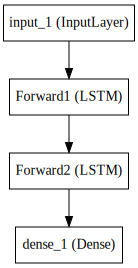

In [6]:
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model_1).create(prog='dot', format='svg'))

In [7]:
# Train
batch_size = 128

print("Train...")
history = model_1.fit(X_train, y_train, batch_size=batch_size, nb_epoch=20,
                      validation_data=(X_test, y_test))

Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/20
25000/25000 [==============================] - 96s - loss: 0.6485 - acc: 0.6096 - val_loss: 0.5060 - val_acc: 0.7569
Epoch 2/20
25000/25000 [==============================] - 95s - loss: 0.4949 - acc: 0.7641 - val_loss: 0.4151 - val_acc: 0.8088
Epoch 3/20
25000/25000 [==============================] - 96s - loss: 0.4343 - acc: 0.7974 - val_loss: 0.3874 - val_acc: 0.8222
Epoch 4/20
25000/25000 [==============================] - 96s - loss: 0.4068 - acc: 0.8119 - val_loss: 0.3690 - val_acc: 0.8327
Epoch 5/20
25000/25000 [==============================] - 95s - loss: 0.3888 - acc: 0.8230 - val_loss: 0.3720 - val_acc: 0.8285
Epoch 6/20
25000/25000 [==============================] - 95s - loss: 0.3710 - acc: 0.8330 - val_loss: 0.3494 - val_acc: 0.8426
Epoch 7/20
25000/25000 [==============================] - 95s - loss: 0.3611 - acc: 0.8371 - val_loss: 0.3532 - val_acc: 0.8418
Epoch 8/20
25000/25000 [=====================

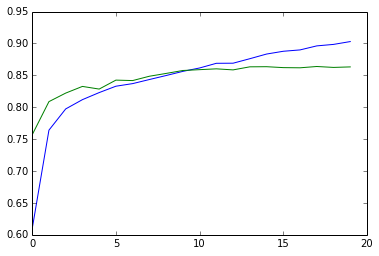

In [8]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

## Validate it

In [9]:
# Score and obtain probabilities
pred_test = model_1.predict(X_test)
print(pred_test.shape)

(25000, 2)


0.86328
AUC:  0.9413207968


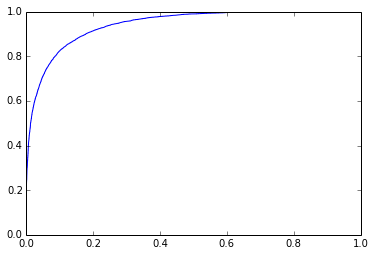

In [10]:
#Import metrics
from sklearn.metrics import roc_curve, auc, accuracy_score

#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

#Calculate accuracy with sklearn
print(accuracy_score(y_test, [1 if p>0.5 else 0 for p in pred_test[:,1]]))

#Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test[:,1])
print 'AUC: ', auc(fpr, tpr)  

#Plot ROC curve
plt.plot(fpr, tpr)

In [11]:
#Evaluate one positive record
i = 1 # 1, 2, ... , 25000
print('Sentence: ',sentences_tst_pos[i])
print('target: ',y_test_full[i])
print('Prediction [neg, pos]: ', pred_test[i])

('Sentence: ', "This short was the first short released by Paramount Famous Studios and was one of several done by the studio showing Popeye engaged directly against the enemy, most often the Japanese. While Warner Brothers, Disney and, to a lesser extent, other studios, did shorts often depicting Germans as foils, the majority of Famous Studios efforts focused on the Japanese. Given Pearl Harbor and Popeye's naval ties, this is quite understandable. This is an average short. Seein' Red, White an' Blue and Spinach For Britain have aged better. But it's still worth watching. Recommended.")
('target: ', 1)
('Prediction [neg, pos]: ', array([ 0.01615579,  0.98384422]))


In [12]:
#Evaluate one negative record
i = -2 # -2, -3, ... -25000
print('Sentence: ',sentences_tst_neg[i])
print('target: ',y_test[i])
print('Prediction [neg, pos]: ', pred_test[i])

('Sentence: ', "You have to start worrying when you see that Michael Madsen is leading the Cast of any movie. I wont go through the list of shame that is his movie career.<br /><br />I watched 45 minutes and still was not sure what really was going on. The movie consisted of a love hate relationship between Madsen and Argento, Which basically was Madsen insulting her, threatening violence and generally treating her like dirt. She on the other hand loves him, then shes doesn't, then she does, the she desires him, then she loves him again......whats wrong with you woman !!!! <br /><br />The Script is awful, lousy soundtrack and pointless aggressive and crude sexuality which i believe was added to entice some viewers as the movie has little else to offer. I would have given the movie a 1 but it just about managed a 2 with a little excitement in the last 20 minutes. It did actually answer one question in the final few minutes but i am not going to share that, i will make you suffer for the